In [1]:

import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

tf.config.list_physical_devices('GPU')
    

#%run pre_processing.ipyn

Tensorflow: 2.3.0


[]

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
hyp_par_len = 120

In [4]:

cvs_path = (r'C:\Users\Josh\Documents\4th Year Docs\Dist+Con\CA Group\Stockcsvs\MSFT_daily.csv')

df = pd.read_csv(cvs_path, delimiter=',', usecols=['date', '1. open', '2. high', '3. low', '4. close', '5. volume'])

# 0 values cause division error
df['5. volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('date', inplace=False)
df.tail()

df[['1. open', '2. high', '3. low', '4. close', '5. volume']] = df[['1. open', '2. high', '3. low', '4. close', '5. volume']].rolling(10).mean()

df.dropna(how='any', axis=0, inplace=True)

df.head

<bound method NDFrame.head of             date  1. open    2. high     3. low  4. close   5. volume
9     2021-01-04  216.310  218.26699  214.19329   216.018  27491013.0
10    2020-12-31  217.128  219.11599  214.95829   216.995  26410575.0
11    2020-12-30  218.060  219.93299  215.83129   217.861  25503135.0
12    2020-12-29  219.289  220.97499  216.79663   218.642  25234748.3
13    2020-12-28  220.084  221.86799  217.76661   219.645  24696184.3
...          ...      ...        ...        ...       ...         ...
5332  1999-11-05   87.906   89.21700   86.53700    88.055  42469420.0
5333  1999-11-04   88.643   89.91100   87.11800    88.736  41956730.0
5334  1999-11-03   89.293   90.55500   87.76800    89.436  40841630.0
5335  1999-11-02   89.874   91.23000   88.37500    89.961  40200820.0
5336  1999-11-01   90.374   91.79900   88.89300    90.498  40509860.0

[5328 rows x 6 columns]>

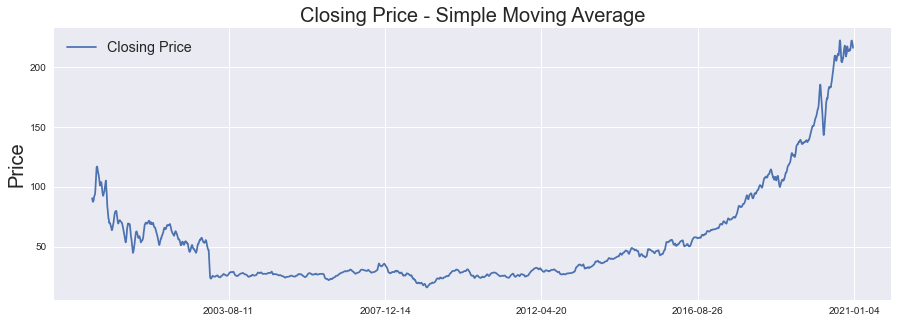

In [5]:
#Plot Closing Price
plt.figure(figsize=(15, 5))
plt.plot(df['4. close'])
plt.xticks(range(0, df.shape[0], 1095), df['date'].loc[::1095], rotation=0)
plt.ylabel('Price', fontsize=20)
plt.title("Closing Price - Simple Moving Average", fontsize=20)
plt.legend(['Closing Price'], fontsize='x-large', loc='best')
plt.gca().invert_xaxis()
plt.show()

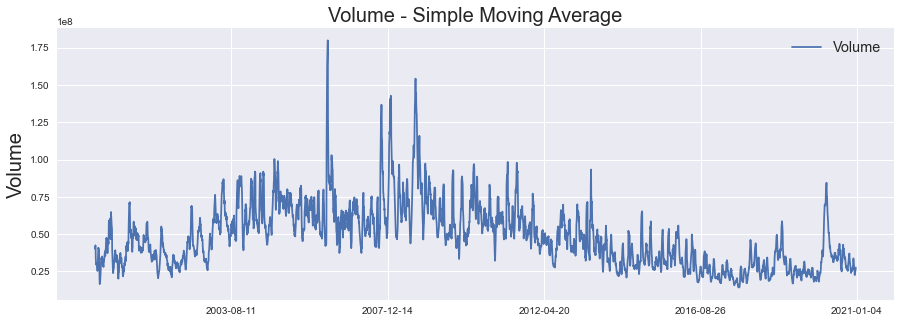

In [6]:
#Plot Volume
plt.figure(figsize=(15, 5))
plt.plot(df['5. volume'])
plt.xticks(range(0, df.shape[0], 1095), df['date'].loc[::1095], rotation=0)
plt.ylabel('Volume', fontsize=20)
plt.title("Volume - Simple Moving Average", fontsize=20)
plt.legend(['Volume'], fontsize='x-large', loc='best')
plt.gca().invert_xaxis()
plt.show()

In [7]:
#Calculate the normalised percentage change in each column

df['1. open'] = df['1. open'].pct_change()
df['2. high'] = df['2. high'].pct_change()
df['3. low'] = df['3. low'].pct_change()
df['4. close'] = df['4. close'].pct_change()
df['5. volume'] = df['5. volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True)

#Price
min_ret = min(df[['1. open', '2. high', '3. low', '4. close']].min(axis=0))
max_ret = max(df[['1. open', '2. high', '3. low', '4. close']].max(axis=0))

df['1. open'] = (df['1. open'] - min_ret) / (max_ret - min_ret)
df['2. high'] = (df['2. high'] - min_ret) / (max_ret - min_ret)
df['3. low'] = (df['3. low'] - min_ret) / (max_ret - min_ret)
df['4. close'] = (df['4. close'] - min_ret) / (max_ret - min_ret)

#Volume
min_volume = df['5. volume'].min(axis=0)
max_volume = df['5. volume'].max(axis=0)

df['5. volume'] = (df['5. volume'] - min_volume) / (max_volume - min_volume)

In [8]:
#Split data into training, validation and test subsets
times = sorted(df.index.values)
last_15pct = sorted(df.index.values)[-int(0.15*len(times))]
last_30pct = sorted(df.index.values)[-int(0.30*len(times))]

df_training = df[(df.index < last_30pct)]
df_validation = df[(df.index >= last_30pct) & (df.index < last_15pct)]
df_test = df[(df.index >= last_15pct)]

#date gets removed
df_training.drop(columns=['date'], inplace=True)
df_validation.drop(columns=['date'], inplace=True)
df_test.drop(columns=['date'], inplace=True)

#Make arrays
train_data = df_training.values
val_data = df_validation.values
test_data = df_test.values
print('Training shape: {}'.format(train_data.shape))
print('Validation shape: {}'.format(val_data.shape))
print('Test shape: {}'.format(test_data.shape))

df_training.head()

Training shape: (3729, 5)
Validation shape: (799, 5)
Test shape: (799, 5)


,1. open,2. high,3. low,4. close,5. volume
10,0.264220,0.265024,0.262658,0.269729,0.457927
11,0.268017,0.263826,0.266299,0.265775,0.462529
12,0.278005,0.271328,0.269357,0.262757,0.484718
13,0.263058,0.266149,0.269368,0.270210,0.474646
14,0.246072,0.251856,0.251367,0.253910,0.447409


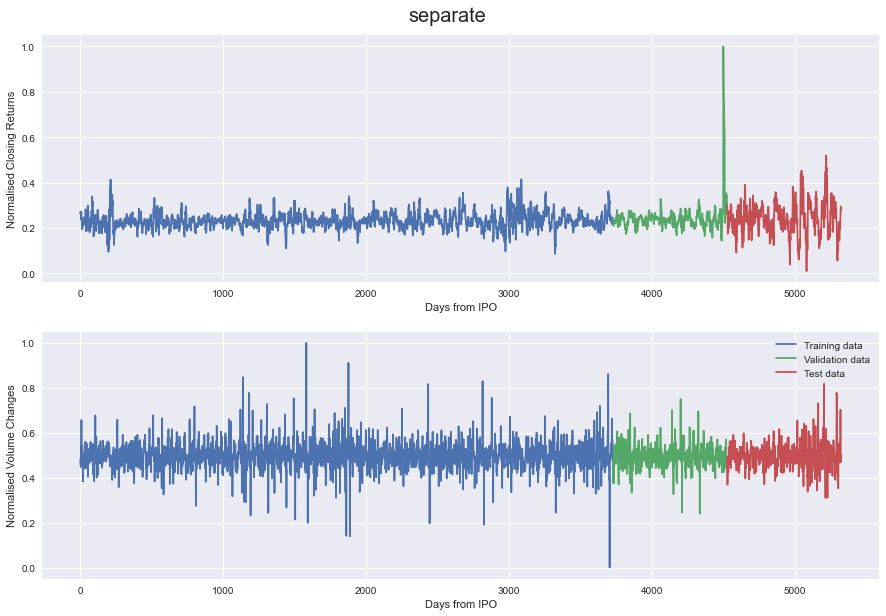

In [9]:
#Closing price and Volume daily changes
figure = plt.figure(figsize=(15,10))
suptitle = figure.suptitle("separate", fontsize=20)
suptitle.set_y(0.92)


ax1 = figure.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_training['4. close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_validation['4. close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['4. close'], label='Test data')
ax1.set_xlabel('Days from IPO')
ax1.set_ylabel('Normalised Closing Returns')


ax2 = figure.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_training['5. volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_validation['5. volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['5. volume'], label='Test data')
ax2.set_xlabel('Days from IPO')
ax2.set_ylabel('Normalised Volume Changes')

plt.legend(loc='best')

In [10]:
#Split into subsections of data for efficiency and specific tuning
#Trasining
X_training, y_training = [], []
for i in range(hyp_par_len, len(train_data)):
  X_training.append(train_data[i-hyp_par_len:i]) # Chunks of training data with a length of 128 df-rows
  y_training.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_training, y_training = np.array(X_training), np.array(y_training)

# Validation
X_validation, y_validation = [], []
for i in range(hyp_par_len, len(val_data)):
    X_validation.append(val_data[i-hyp_par_len:i])
    y_validation.append(val_data[:, 3][i])
X_validation, y_validation = np.array(X_validation), np.array(y_validation)

# Test
X_test, y_test = [], []
for i in range(hyp_par_len, len(test_data)):
    X_test.append(test_data[i-hyp_par_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_training.shape, y_training.shape)
print(X_validation.shape, y_validation.shape)


(3609, 120, 5) (3609,)
(679, 120, 5) (679,)


Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.02142, saving model to LSTM.hdf5
2/2 - 12s - loss: 0.0687 - mae: 0.2581 - mape: 116.0321 - val_loss: 0.0214 - val_mae: 0.1392 - val_mape: 59.6555
Epoch 2/20

Epoch 00002: val_loss improved from 0.02142 to 0.01142, saving model to LSTM.hdf5
2/2 - 11s - loss: 0.0132 - mae: 0.0996 - mape: 45.8064 - val_loss: 0.0114 - val_mae: 0.0800 - val_mape: 30.1353
Epoch 3/20

Epoch 00003: val_loss did not improve from 0.01142
2/2 - 10s - loss: 0.0076 - mae: 0.0791 - mape: 32.8005 - val_loss: 0.0139 - val_mae: 0.0940 - val_mape: 35.9952
Epoch 4/20

Epoch 00004: val_loss improved from 0.01142 to 0.00533, saving model to LSTM.hdf5
2/2 - 10s - loss: 0.0053 - mae: 0.0622 - mape: 25.6977 - val_loss: 0.0053 - val_mae: 0.0386 - val_mape: 15.2281
Epoch 5/20

Epoch 00005: val_loss did not improve from 0.00533
2/2 - 11s - loss: 0.0035 - mae: 0.0510 - mape: 24.0224 - val_loss: 0.0070 - val_mae: 0.0603 - val_mape: 25.1576
Epoch 6/20

Epoch 00006: val_loss d

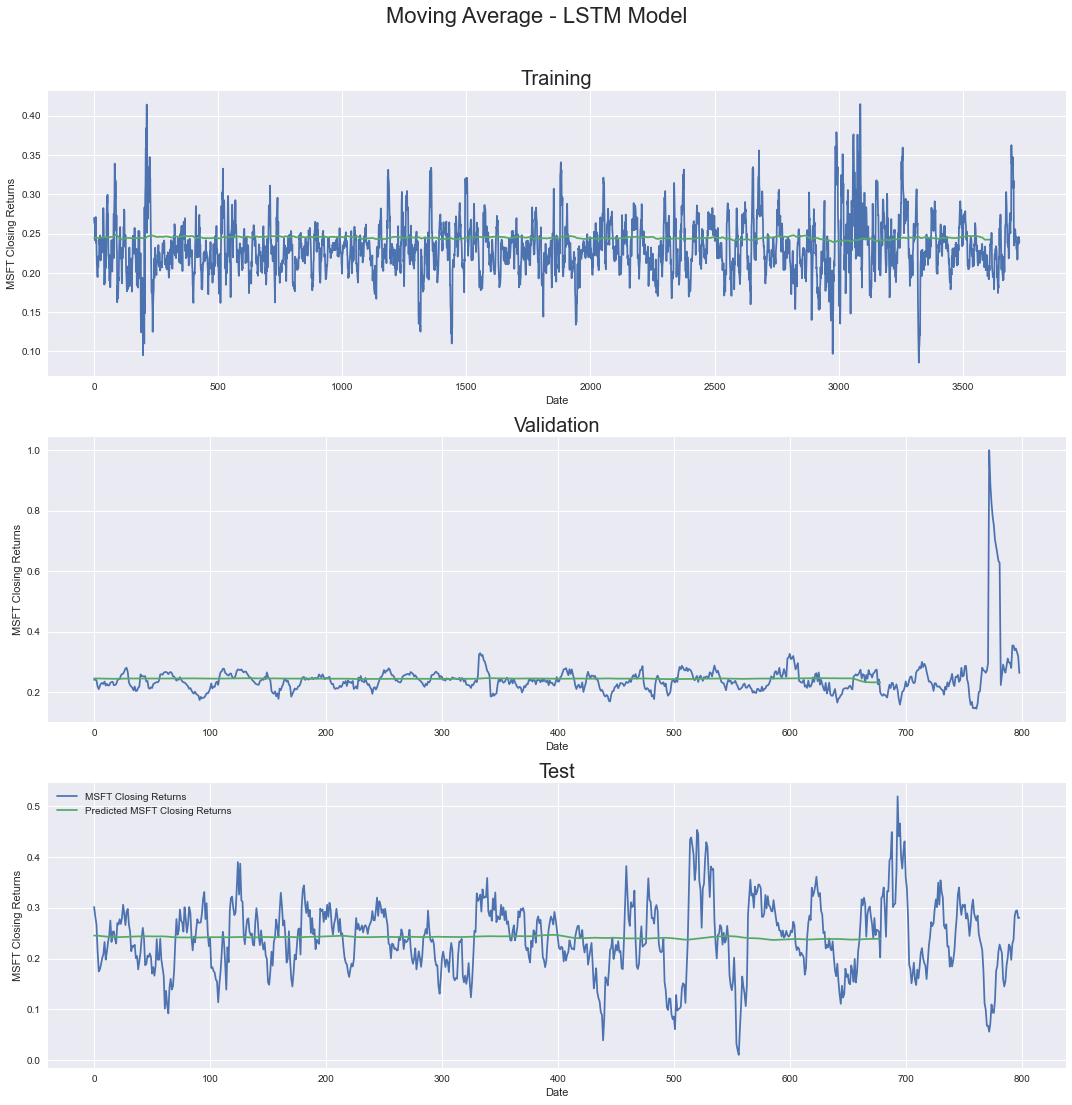

In [11]:
def LSTM_model():
  sequence = Input(shape = (hyp_par_len, 5))
      
  x = Bidirectional(LSTM(128, return_sequences=True))(sequence)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 

#Pooling
  avg_pooling = GlobalAveragePooling1D()(x)
  max_pooling = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pooling, max_pooling])
#Linear Activation Function
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)      

  lstm = Model(inputs=sequence, outputs=out)
  lstm.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])    
  return lstm

lstm = LSTM_model()

callback = tf.keras.callbacks.ModelCheckpoint('LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

lstm.fit(X_training, y_training,
              batch_size=2048,
              verbose=2,
              callbacks=[callback],
              epochs=20,
              validation_data=(X_validation, y_validation),)    

lstm = tf.keras.models.load_model(r'C:\Users\Josh\Documents\4th Year Docs\Dist+Con\CA Group\LSTM.hdf5')

#Prdict
train_pred = lstm.predict(X_training)
val_pred = lstm.predict(X_validation)
test_pred = lstm.predict(X_test)

#Print evaluation metrics for all datasets
training_eval = lstm.evaluate(X_training, y_training, verbose=0)
validation_eval = lstm.evaluate(X_validation, y_validation, verbose=0)
test_eval = lstm.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Metrics')
print('Training - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(training_eval[0], training_eval[1], training_eval[2]))
print('Validation - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(validation_eval[0], validation_eval[1], validation_eval[2]))
print('Test - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

#Plot results
figure = plt.figure(figsize=(15,15))
suptitle = figure.suptitle("Moving Average - LSTM Model", fontsize=22)
suptitle.set_y(1.02)

#training
ax11 = figure.add_subplot(311)
ax11.plot(train_data[:, 3], label='MSFT Closing Returns')
ax11.plot(train_pred, label='Predicted MSFT Closing Returns')
ax11.set_title("Training", fontsize=20)
ax11.set_xlabel('Date')
ax11.set_ylabel('MSFT Closing Returns')

#validation
ax21 = figure.add_subplot(312)
ax21.plot(val_data[:, 3], label='MSFT Closing Returns')
ax21.plot(val_pred, label='Predicted MSFT Closing Returns')
ax21.set_title("Validation", fontsize=20)
ax21.set_xlabel('Date')
ax21.set_ylabel('MSFT Closing Returns')

#test
ax31 = figure.add_subplot(313)
ax31.plot(test_data[:, 3], label='MSFT Closing Returns')
ax31.plot(test_pred, label='Predicted MSFT Closing Returns')
ax31.set_title("Test", fontsize=20)
ax31.set_xlabel('Date')
ax31.set_ylabel('MSFT Closing Returns')
 
plt.tight_layout()
plt.legend(loc='best')